#Imports and functions

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.spatial.distance import pdist, mahalanobis, squareform

from scipy.stats import chi2

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, recall_score
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN

from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from imblearn.ensemble import BalancedRandomForestClassifier

plt.rcParams['figure.figsize'] = 12, 10
plt.style.use('bmh')

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from zipfile import ZipFile
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
#input: pd.DataFrame
#output: lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#summary: finds limits of provided data using IQR
def find_limits(data):
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  return lower_limit, upper_limit


#input: data: pd.DataFrame, lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#output: int
#summary: finds number of outliers of provided data using limits
def count_outliers(data, lower_limit, upper_limit):
  return len(data[data > upper_limit] + data[data < lower_limit])


#input: data: pd.DataFrame, lower_limit: Series([], dtype: float64), upper_limit: Series([], dtype: float64)
#summary: plots data distribution with limit lines
def create_hist_with_outliers(data, lower_limit, upper_limit):
  sns.distplot(x=data, axlabel=data.name).set(title=f'{data.name} distribution')
  plt.axvline(upper_limit, linewidth=1 , color = 'red')
  plt.axvline(lower_limit, linewidth=1 , color = 'red')
  plt.show()

In [ ]:
#input: x : vector or matrix of data with, say, p columns;
#       data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed
#       cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data
#summary: computes the Mahalanobis Distance between each row of x and the data
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [ ]:
#evaluates mutual information score for each feature
def make_mi_scores(X,Y):
    mi_scores=mutual_info_classif(X,Y)
    mi_scores=pd.Series(mi_scores ,name="MI_scores",index=X.columns)
    mi_scores=mi_scores.sort_values(ascending=False)
    return(mi_scores)

In [ ]:
def grid_search(model, param, cv, X, y):
  grid = GridSearchCV(model,param,scoring='roc_auc',refit=True,cv=cv, error_score='raise')
  grid.fit(X,y)
  print('Best roc-auc: {}, with best: {}'.format(grid.best_score_, grid.best_params_))
  return grid.best_estimator_


#input: model: estimator object; X_train, X_test: array-like of shape (n_samples, n_features);
#       y_train, y_test: array-like of shape (n_samples, n_output) or (n_samples,);
#summary: fits, predicts model and prints results
def build_model(model, X_train, y_train, X_test, y_test):
  # fit it
  model.fit(X_train,y_train)
  # test
  y_pred = model.predict(X_test)
  # performance
  print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
  print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
  print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
  print(f'Recall score: {recall_score(y_test,y_pred)}')
  print(classification_report(y_test, y_pred))


#input: model_name: string, data_type: string
#summary: prints model name and data type
def print_model(model_name, data_type):
  print('--------------------------------------------')
  print('Model ', model_name)
  print('Data type ', data_type)

#EDA

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Cardiotocography.csv')
df.head()

id        LB        AC        FM        UC      ASTV      MSTV  \
0  1881.0  0.592593  0.000000  0.000000  0.294118  0.633803  0.338235   
1   421.0  0.574074  0.038462  0.000000  0.000000  0.816901  0.029412   
2    92.0  0.777778  0.000000  0.000000  0.000000  0.774648  0.029412   
3  1767.0  0.259259  0.000000  0.000000  0.294118  0.704225  0.191176   
4  1880.0  0.592593  0.000000  0.001773  0.294118  0.633803  0.352941   

       ALTV      MLTV        DL  ...       Min       Max      Nmax  Nzeros  \
0  0.000000  0.013807  0.500000  ...  0.045872  0.336207  0.333333     0.1   
1  0.527473  0.092702  0.000000  ...  0.770642  0.672414  0.166667     0.0   
2  0.736264  0.096647  0.000000  ...  0.816514  0.275862  0.222222     0.0   
3  0.000000  0.183432  0.428571  ...  0.174312  0.275862  0.222222     0.1   
4  0.000000  0.013807  0.428571  ...  0.045872  0.336207  0.333333     0.1   

       Mode      Mean    Median  Variance  Tendency  outlier  
0  0.485149  0.247423  0.284091  0.638418       1.0   b'yes'  
1  0.534653  0.587629  0.511364  0.016949       0.0   b'yes'  
2  0.633663  0.659794  0.602273  0.000000       1.0   b'yes'  
3  0.000000  0.164948  0.000000  0.361582       0.0   b'yes'  
4  0.485149  0.226804  0.272727  0.683616       1.0   b'yes'  

[5 rows x 23 columns]

In [ ]:
df.shape

(16880, 23)

There are 16880 records and 23 features.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        16880 non-null  float64
 1   LB        16880 non-null  float64
 2   AC        16880 non-null  float64
 3   FM        16880 non-null  float64
 4   UC        16880 non-null  float64
 5   ASTV      16880 non-null  float64
 6   MSTV      16880 non-null  float64
 7   ALTV      16880 non-null  float64
 8   MLTV      16880 non-null  float64
 9   DL        16880 non-null  float64
 10  DS        16880 non-null  float64
 11  DP        16880 non-null  float64
 12  Width     16880 non-null  float64
 13  Min       16880 non-null  float64
 14  Max       16880 non-null  float64
 15  Nmax      16880 non-null  float64
 16  Nzeros    16880 non-null  float64
 17  Mode      16880 non-null  float64
 18  Mean      16880 non-null  float64
 19  Median    16880 non-null  float64
 20  Variance  16880 non-null  fl

All the features have 'float' data type, so there is no need to change it. There are no missing values.

In [ ]:
df.describe().T

count         mean         std  min         25%          50%  \
id        16880.0  1123.872156  593.610901  1.0  641.000000  1150.500000   
LB        16880.0     0.483186    0.175738  0.0    0.351852     0.481481   
AC        16880.0     0.129270    0.143077  0.0    0.000000     0.076923   
FM        16880.0     0.011411    0.060514  0.0    0.000000     0.000000   
UC        16880.0     0.226668    0.156665  0.0    0.117647     0.235294   
ASTV      16880.0     0.425672    0.216970  0.0    0.236111     0.408451   
MSTV      16880.0     0.179521    0.121198  0.0    0.088235     0.161765   
ALTV      16880.0     0.064739    0.146732  0.0    0.000000     0.000000   
MLTV      16880.0     0.170819    0.114551  0.0    0.094675     0.155819   
DL        16880.0     0.113227    0.171935  0.0    0.000000     0.000000   
DS        16880.0     0.000770    0.027742  0.0    0.000000     0.000000   
DP        16880.0     0.017417    0.084956  0.0    0.000000     0.000000   
Width     16880.0     0.391083    0.214992  0.0    0.204678     0.377907   
Min       16880.0     0.379411    0.252147  0.0    0.155963     0.376147   
Max       16880.0     0.365604    0.153285  0.0    0.258621     0.353448   
Nmax      16880.0     0.230579    0.159211  0.0    0.111111     0.222222   
Nzeros    16880.0     0.033365    0.069209  0.0    0.000000     0.000000   
Mode      16880.0     0.563887    0.128429  0.0    0.482143     0.567797   
Mean      16880.0     0.525497    0.136375  0.0    0.431193     0.525773   
Median    16880.0     0.475086    0.146790  0.0    0.373494     0.478261   
Variance  16880.0     0.090984    0.119737  0.0    0.015385     0.045198   
Tendency  16880.0     0.670794    0.295171  0.0    0.500000     0.500000   

                  75%     max  
id        1619.000000  2126.0  
LB           0.592593     1.0  
AC           0.192308     1.0  
FM           0.003546     1.0  
UC           0.304348     1.0  
ASTV         0.608108     1.0  
MSTV         0.220588     1.0  
ALTV         0.050633     1.0  
MLTV         0.226824     1.0  
DL           0.214286     1.0  
DS           0.000000     1.0  
DP           0.000000     1.0  
Width        0.549133     1.0  
Min          0.596330     1.0  
Max          0.456897     1.0  
Nmax         0.333333     1.0  
Nzeros       0.000000     1.0  
Mode         0.650000     1.0  
Mean         0.621053     1.0  
Median       0.576087     1.0  
Variance     0.122677     1.0  
Tendency     1.000000     1.0

We can see that all the features are scaled to the interval [0;1]. Most of the features probably don't follow a normal distribution (e.g. the 75th percentile of `FM` is close to zero).

Let's take a look at the target distribution.

In [ ]:
df.outlier.value_counts() / df.shape[0]

b'no'     0.98045
b'yes'    0.01955
Name: outlier, dtype: float64

Text(0.5, 1.0, 'Target distribution')

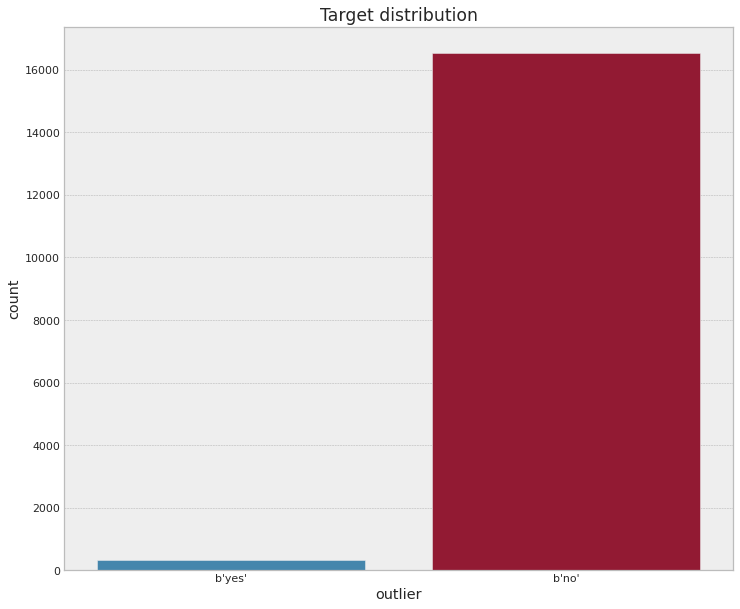

In [ ]:
sns.countplot(data=df, x="outlier").set_title('Target distribution')

The dataset is imbalanced. The content of outliers is only 2%. Let's encode the target using `LabelEncoder`.

In [ ]:
le = LabelEncoder()
df['outlier'] = le.fit_transform(df['outlier'])

Now we can create X and y datasets. The feature `id` is eliminated due to uselessness.

In [ ]:
X = df.drop(columns=['outlier', 'id'])
y = df['outlier']

Let's look at the distributions of features.

LB: lower limit: -0.009259259259259356, upper limit: 0.9537037037037037, outliers: 155


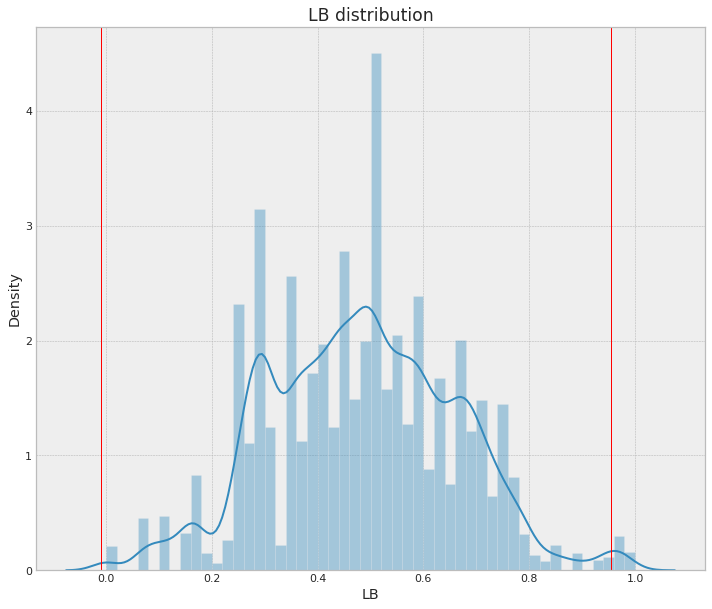

AC: lower limit: -0.28846153846153844, upper limit: 0.4807692307692307, outliers: 500


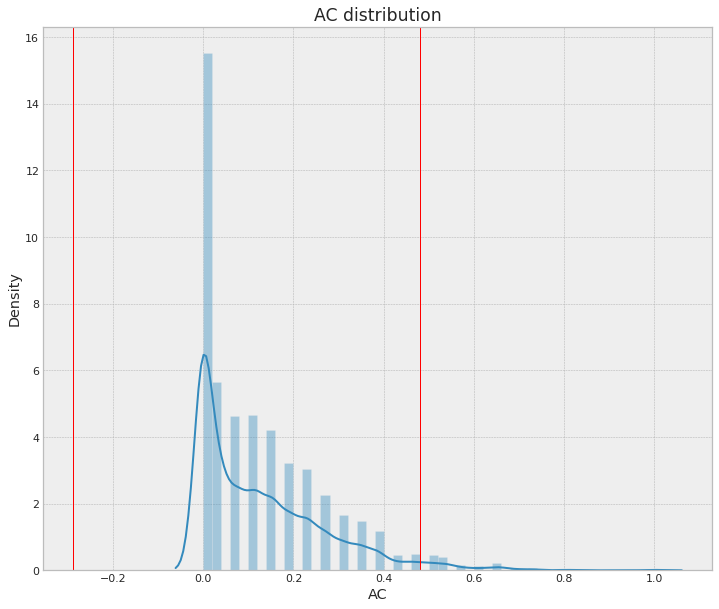

FM: lower limit: -0.00531914893617015, upper limit: 0.00886524822695025, outliers: 2528


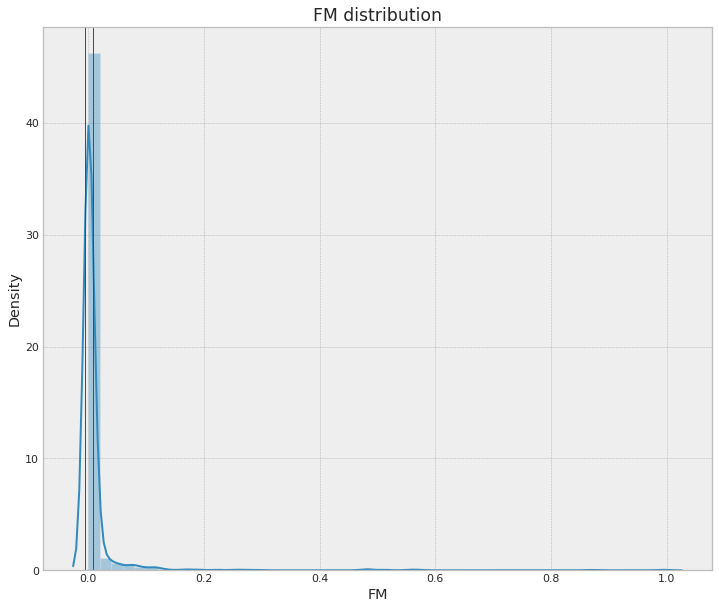

UC: lower limit: -0.16240409207161127, upper limit: 0.5843989769820972, outliers: 508


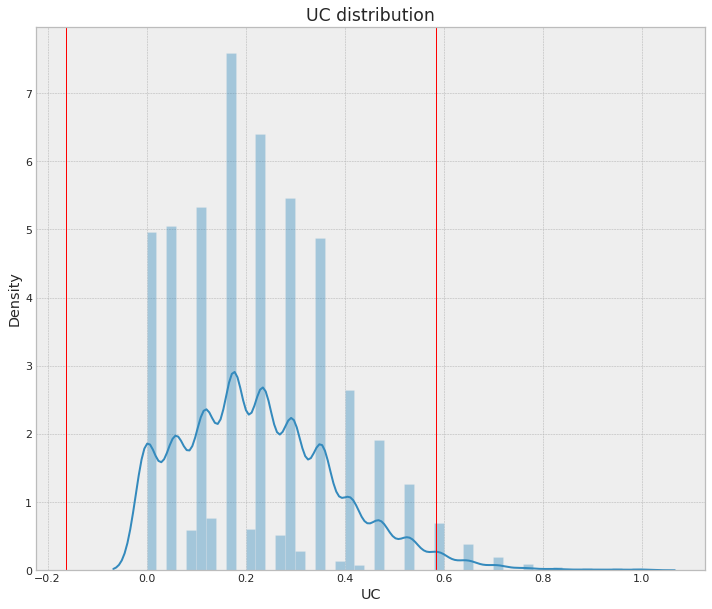

ASTV: lower limit: -0.32188438438438444, upper limit: 1.1661036036036037, outliers: 0


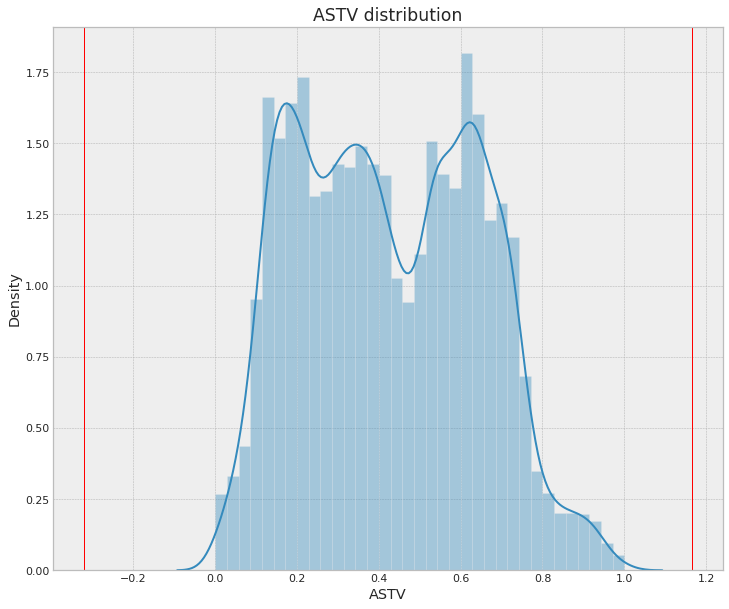

MSTV: lower limit: -0.11029411764705893, upper limit: 0.41911764705882354, outliers: 754


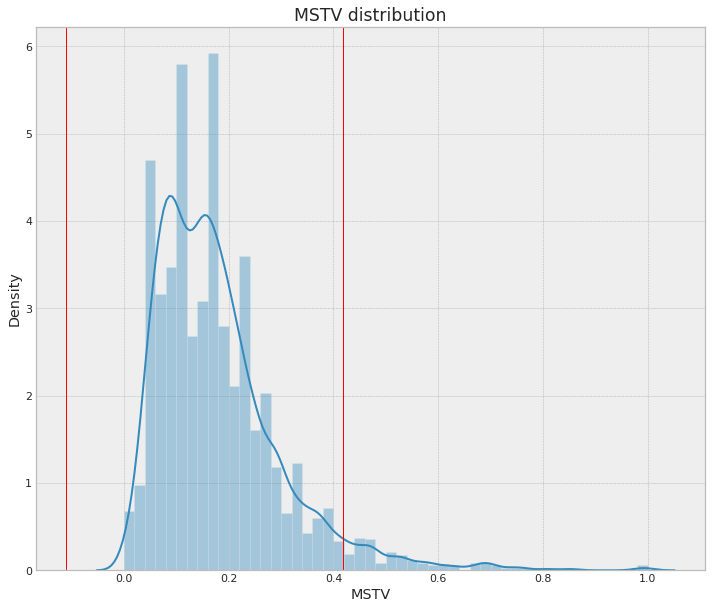

ALTV: lower limit: -0.0759493670886075, upper limit: 0.1265822784810125, outliers: 2714


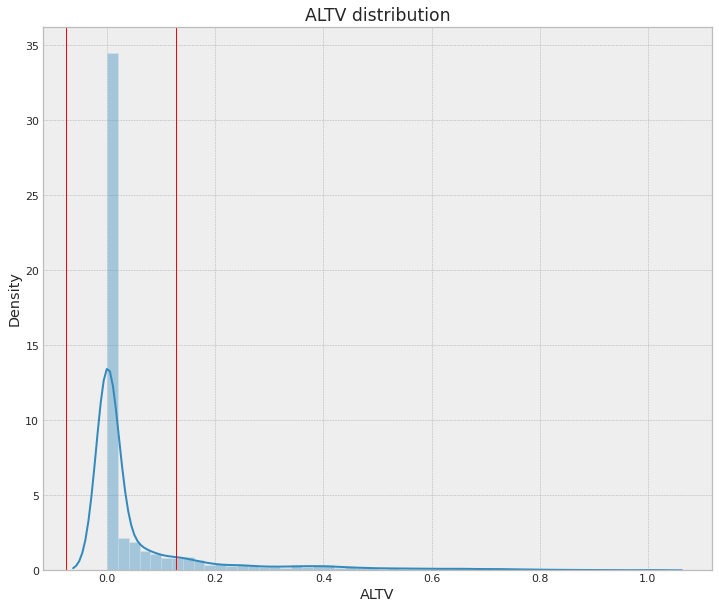

MLTV: lower limit: -0.10355029585798824, upper limit: 0.42504930966469423, outliers: 514


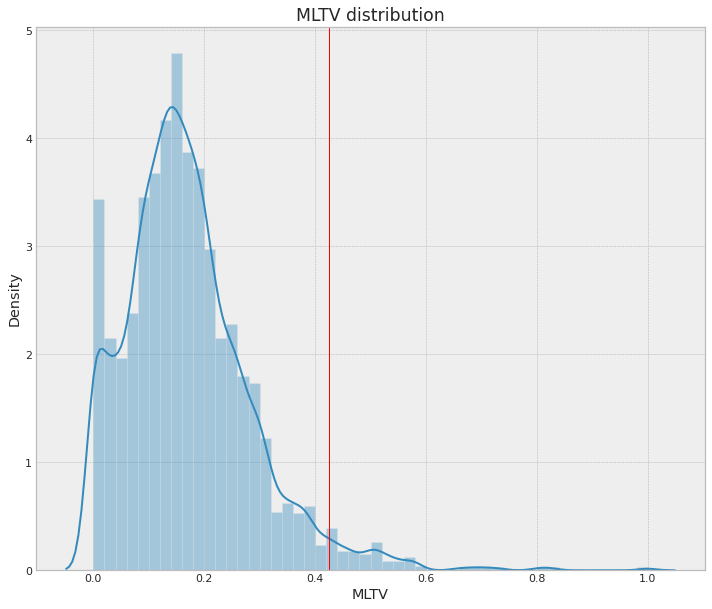

DL: lower limit: -0.3214285714285713, upper limit: 0.5357142857142855, outliers: 510


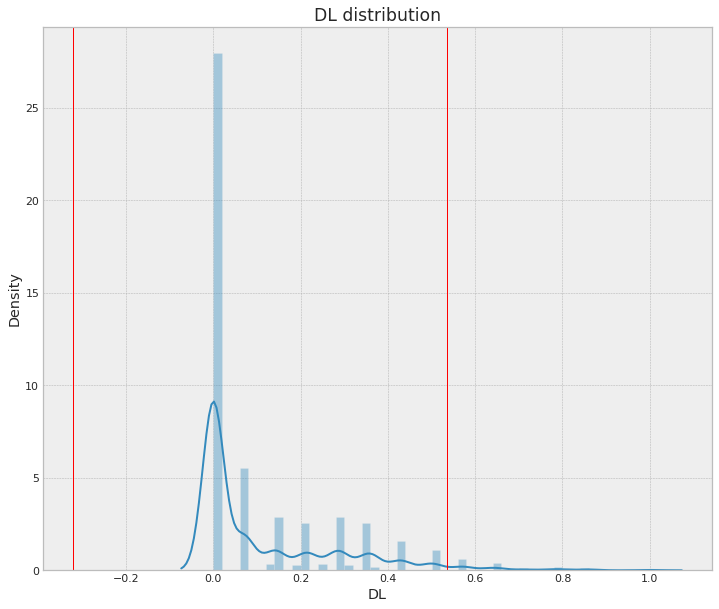

DS: lower limit: 0.0, upper limit: 0.0, outliers: 13


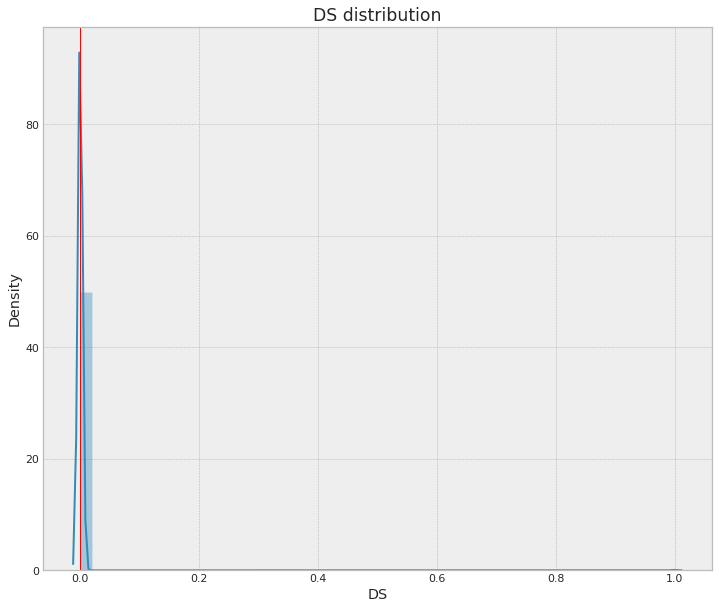

DP: lower limit: 0.0, upper limit: 0.0, outliers: 753


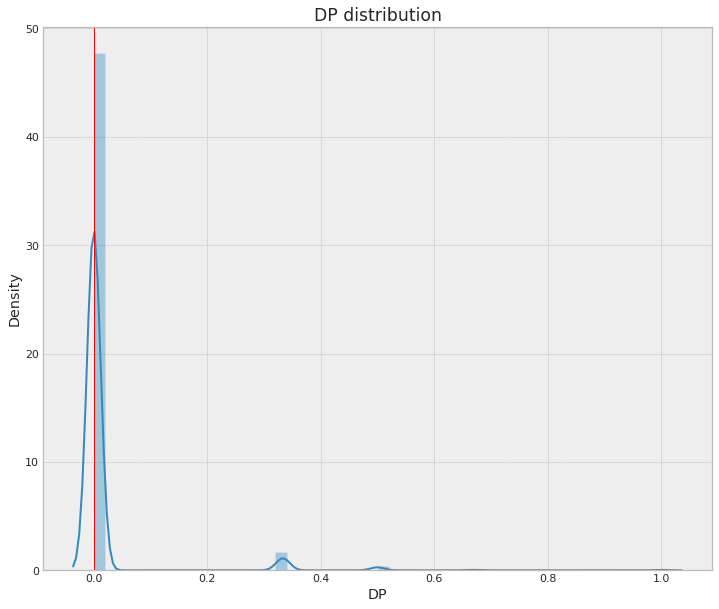

Width: lower limit: -0.3120035155325694, upper limit: 1.0658148260825473, outliers: 0


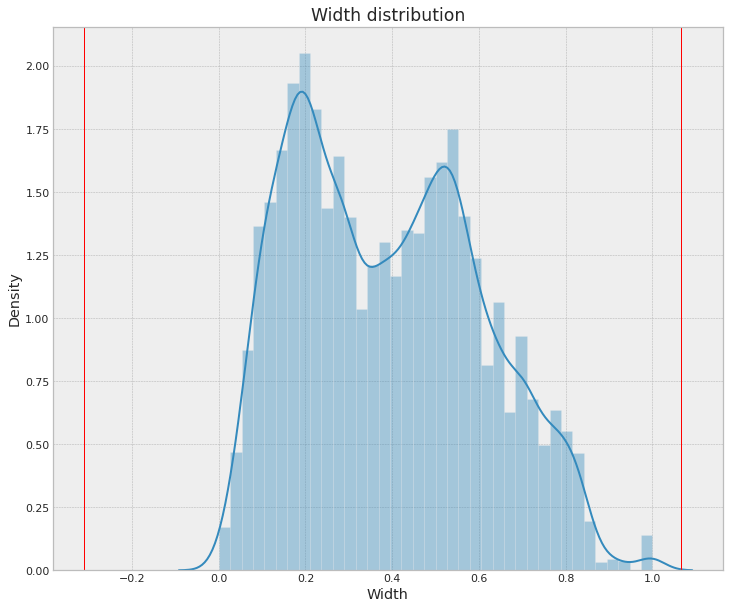

Min: lower limit: -0.5045871559633026, upper limit: 1.256880733944954, outliers: 0


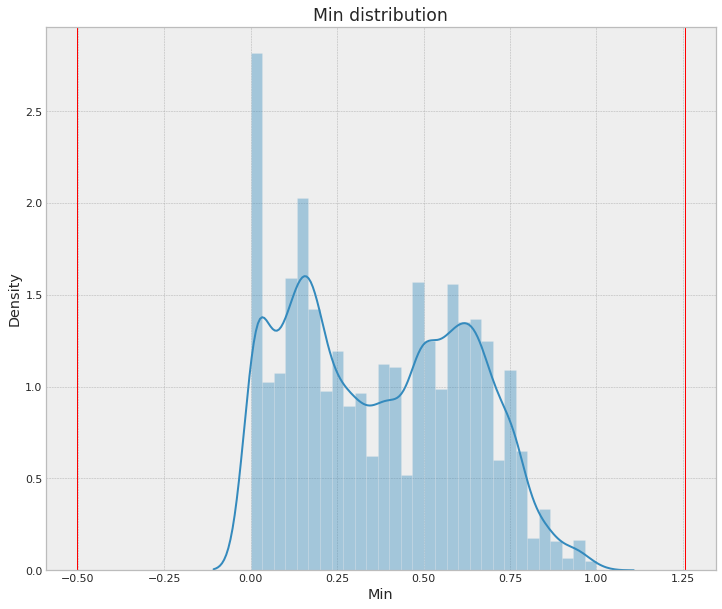

Max: lower limit: -0.03879310344827591, upper limit: 0.7543103448275862, outliers: 182


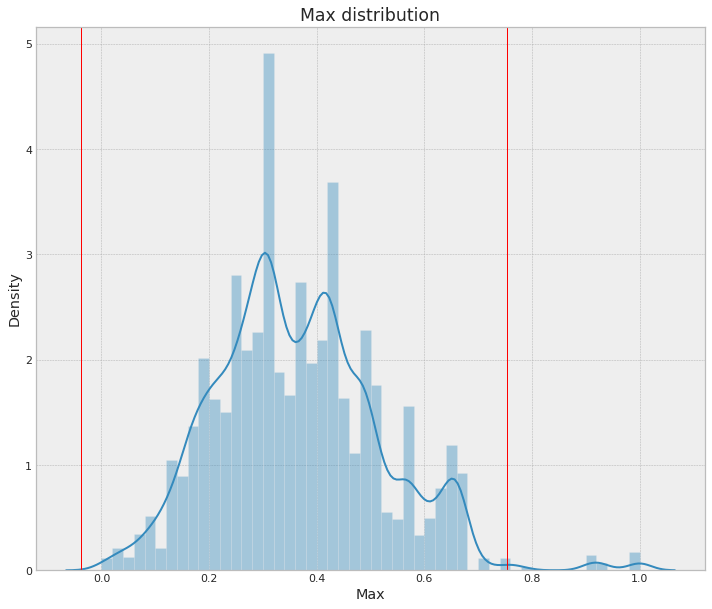

Nmax: lower limit: -0.2222222222222222, upper limit: 0.6666666666666666, outliers: 123


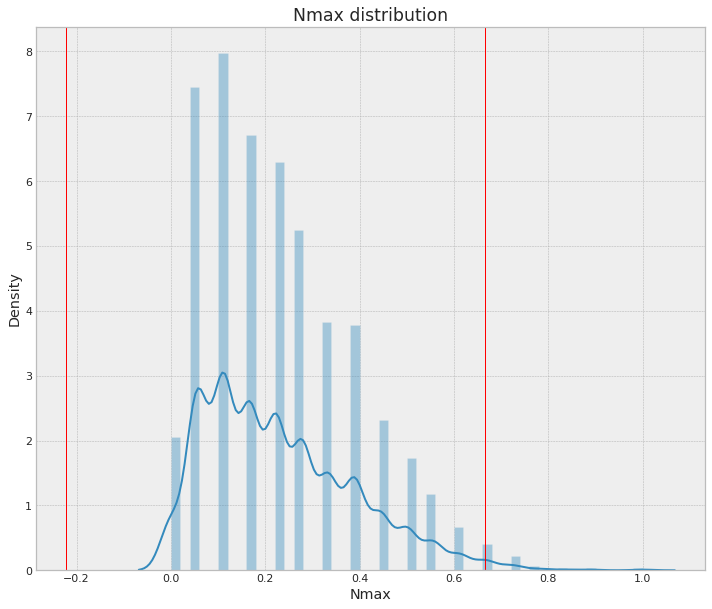

Nzeros: lower limit: 0.0, upper limit: 0.0, outliers: 4176


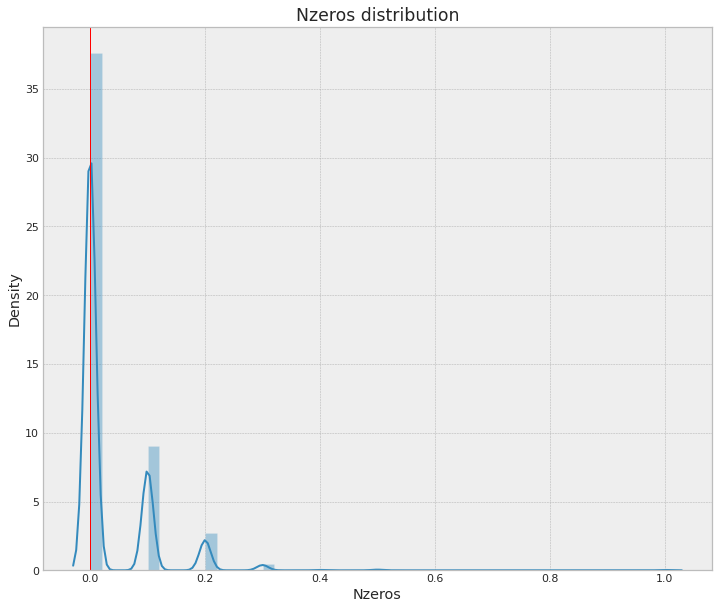

Mode: lower limit: 0.2303571428571427, upper limit: 0.9017857142857144, outliers: 258


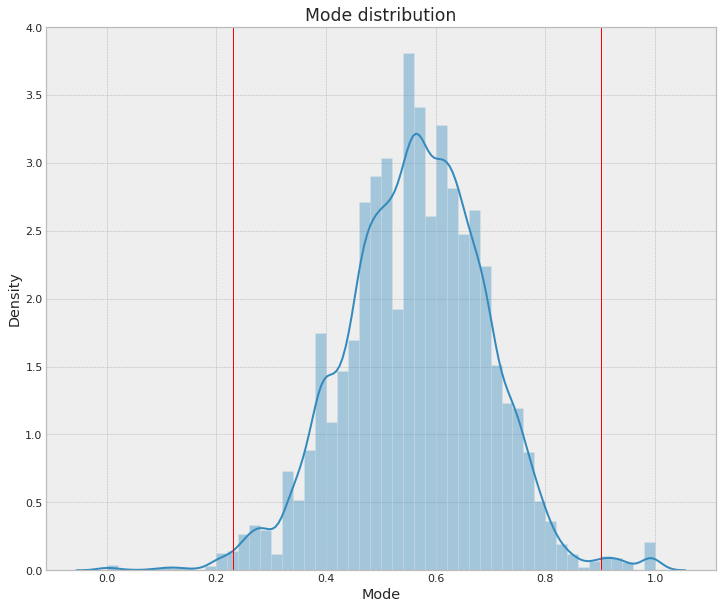

Mean: lower limit: 0.1464027040077256, upper limit: 0.9058425881216805, outliers: 118


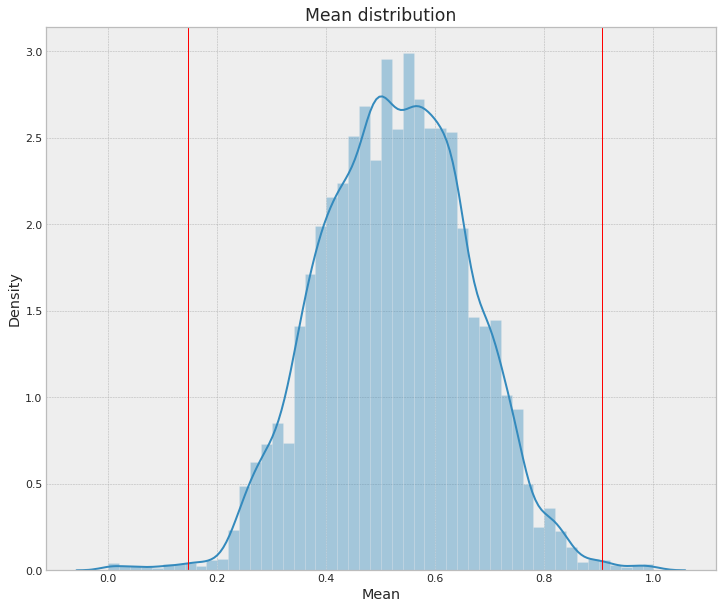

Median: lower limit: 0.06960450497642728, upper limit: 0.8799764274489262, outliers: 103


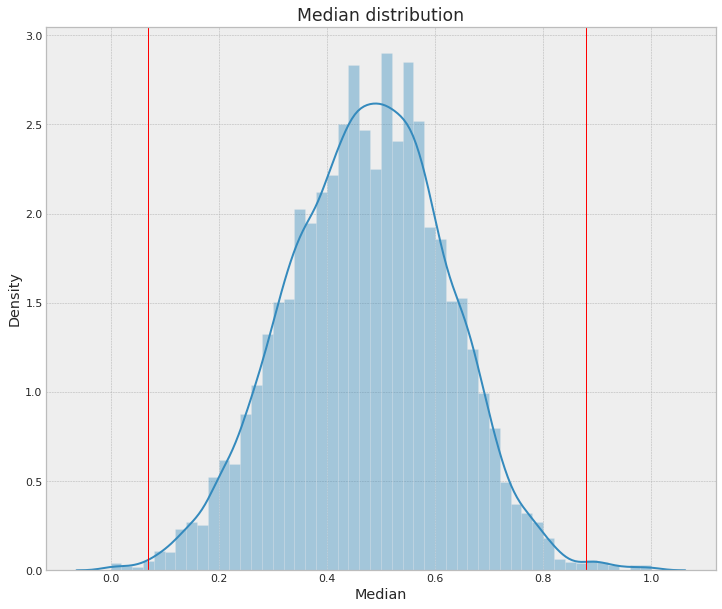

Variance: lower limit: -0.1455533314269375, upper limit: 0.2836145267372033, outliers: 1227


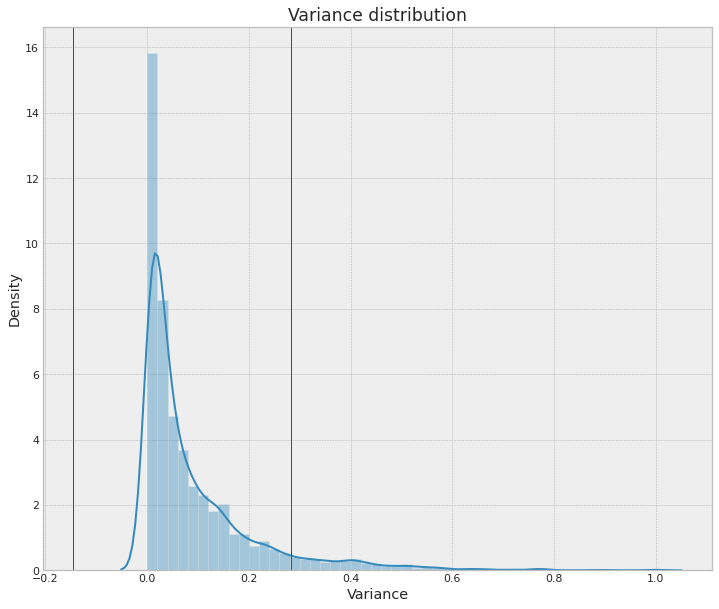

Tendency: lower limit: -0.25, upper limit: 1.75, outliers: 0


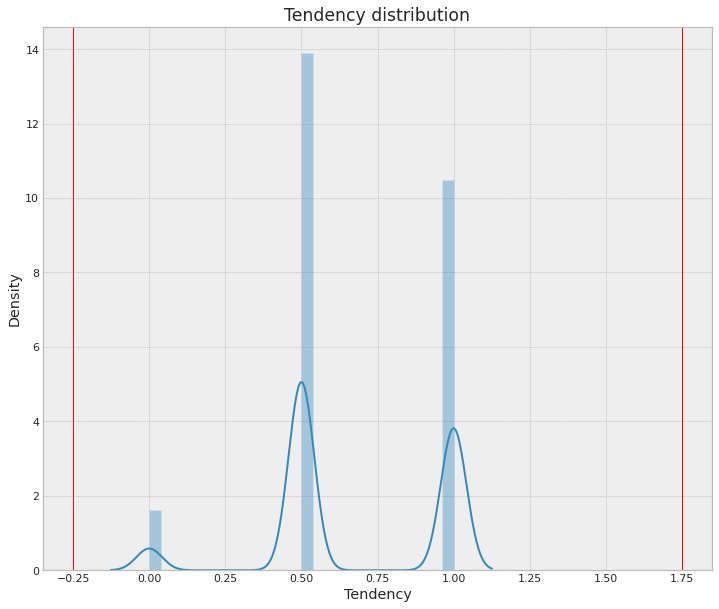

In [ ]:
for feature in X.columns:
  lower_limit, upper_limit = find_limits(df[feature])
  print(f'{feature}: lower limit: {lower_limit}, upper limit: {upper_limit}, outliers: {count_outliers(df[feature], lower_limit, upper_limit)}')
  create_hist_with_outliers(df[feature], lower_limit, upper_limit)

The distribution of most features is very far from normal. Some features appear to have a bimodal distribution. Some functions have many null values. There are a lot of outliers. All this can be complicating circumstances for the model.

Now let's create stripplots and boxplots to see if we can extract any useful information.

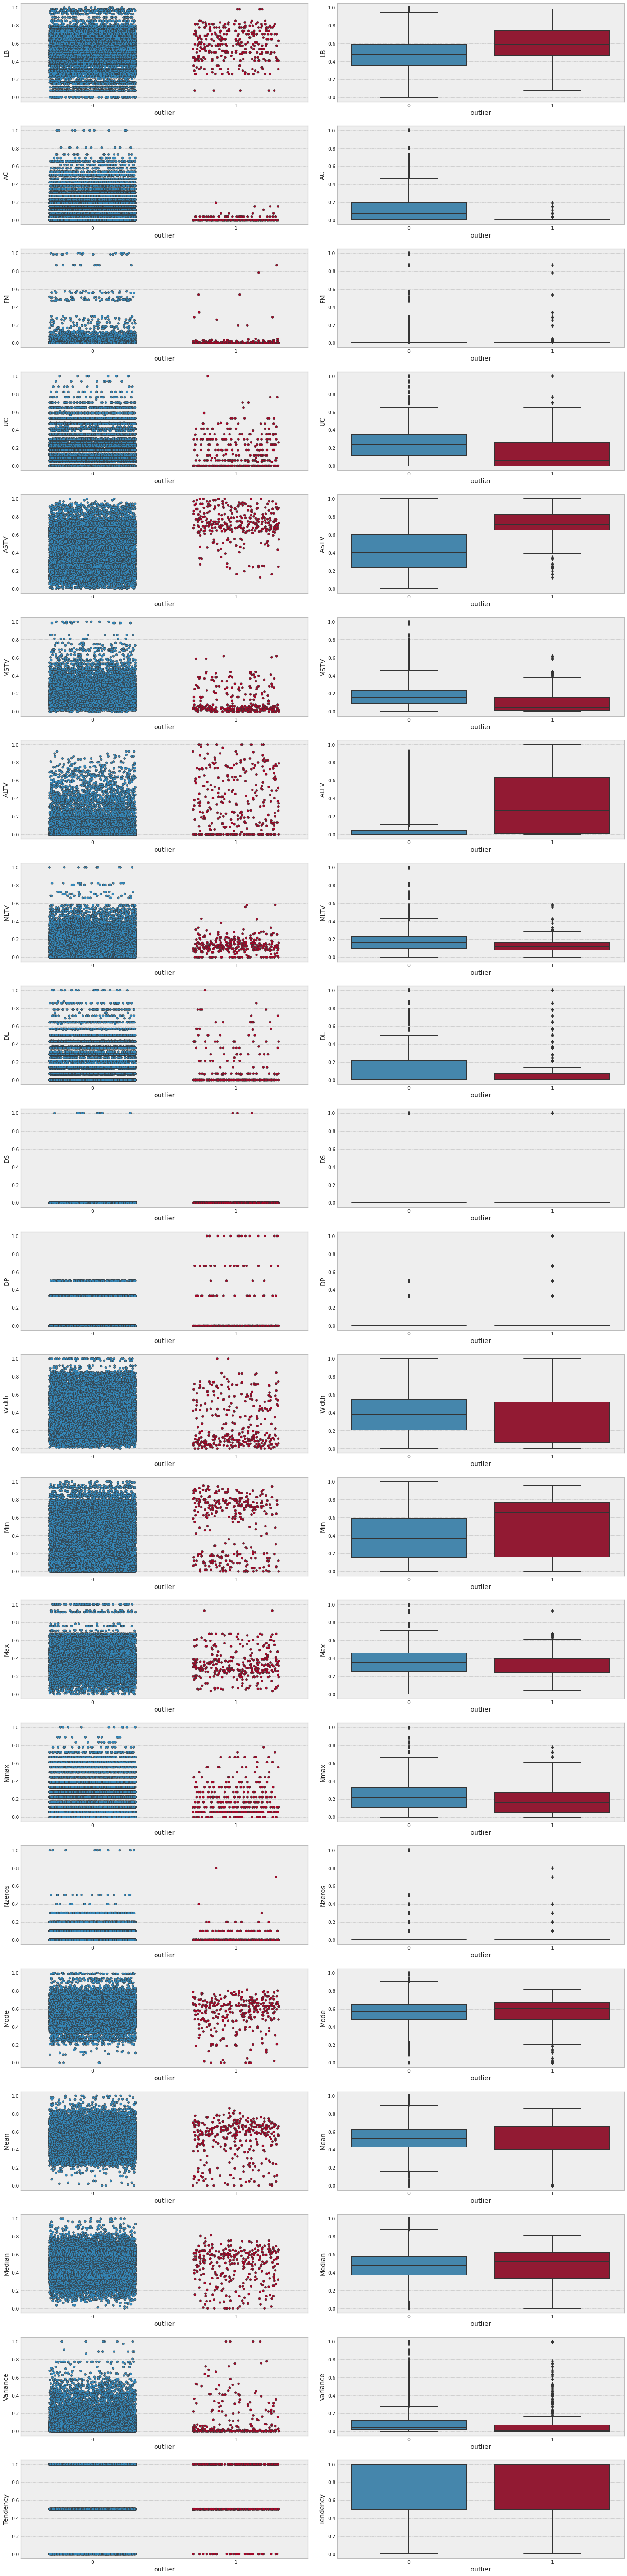

In [ ]:
fig, ax = plt.subplots(len(X.columns), 2, figsize=(20,80))
fig.tight_layout(pad=3.0)
row = 0

for feature in X.columns:
  sns.stripplot(x=df.outlier, y=df[feature], linewidth=0.6, jitter= 0.3, ax=ax[row][0])
  sns.boxplot(x=df.outlier, y=df[feature], ax=ax[row][1])
  row+=1

We can see that the distribution of some features differ depending on the target. The feature `AC` takes values above ~0.2 only when the target value is 0. The feature `ASTV` takes values smaller than 0.1 only when the target value is 0. The feature `MSTV` takes values bigger than ~0.62 only when the target value is 0.

Here we can see how different feature distributions are.

<AxesSubplot:>

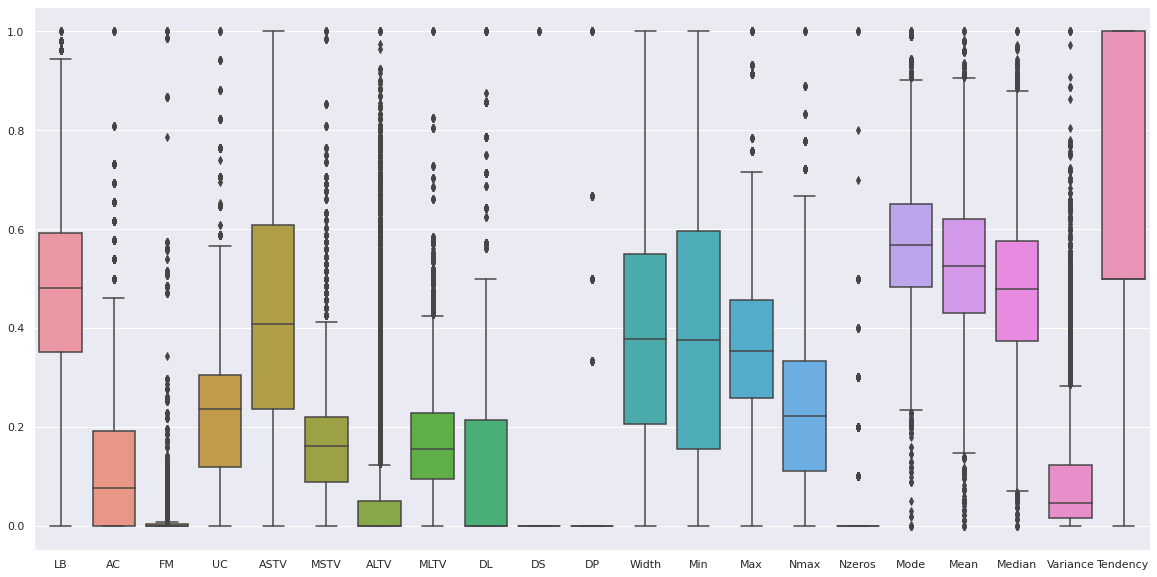

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(data = X)

Let's create the pairplot.

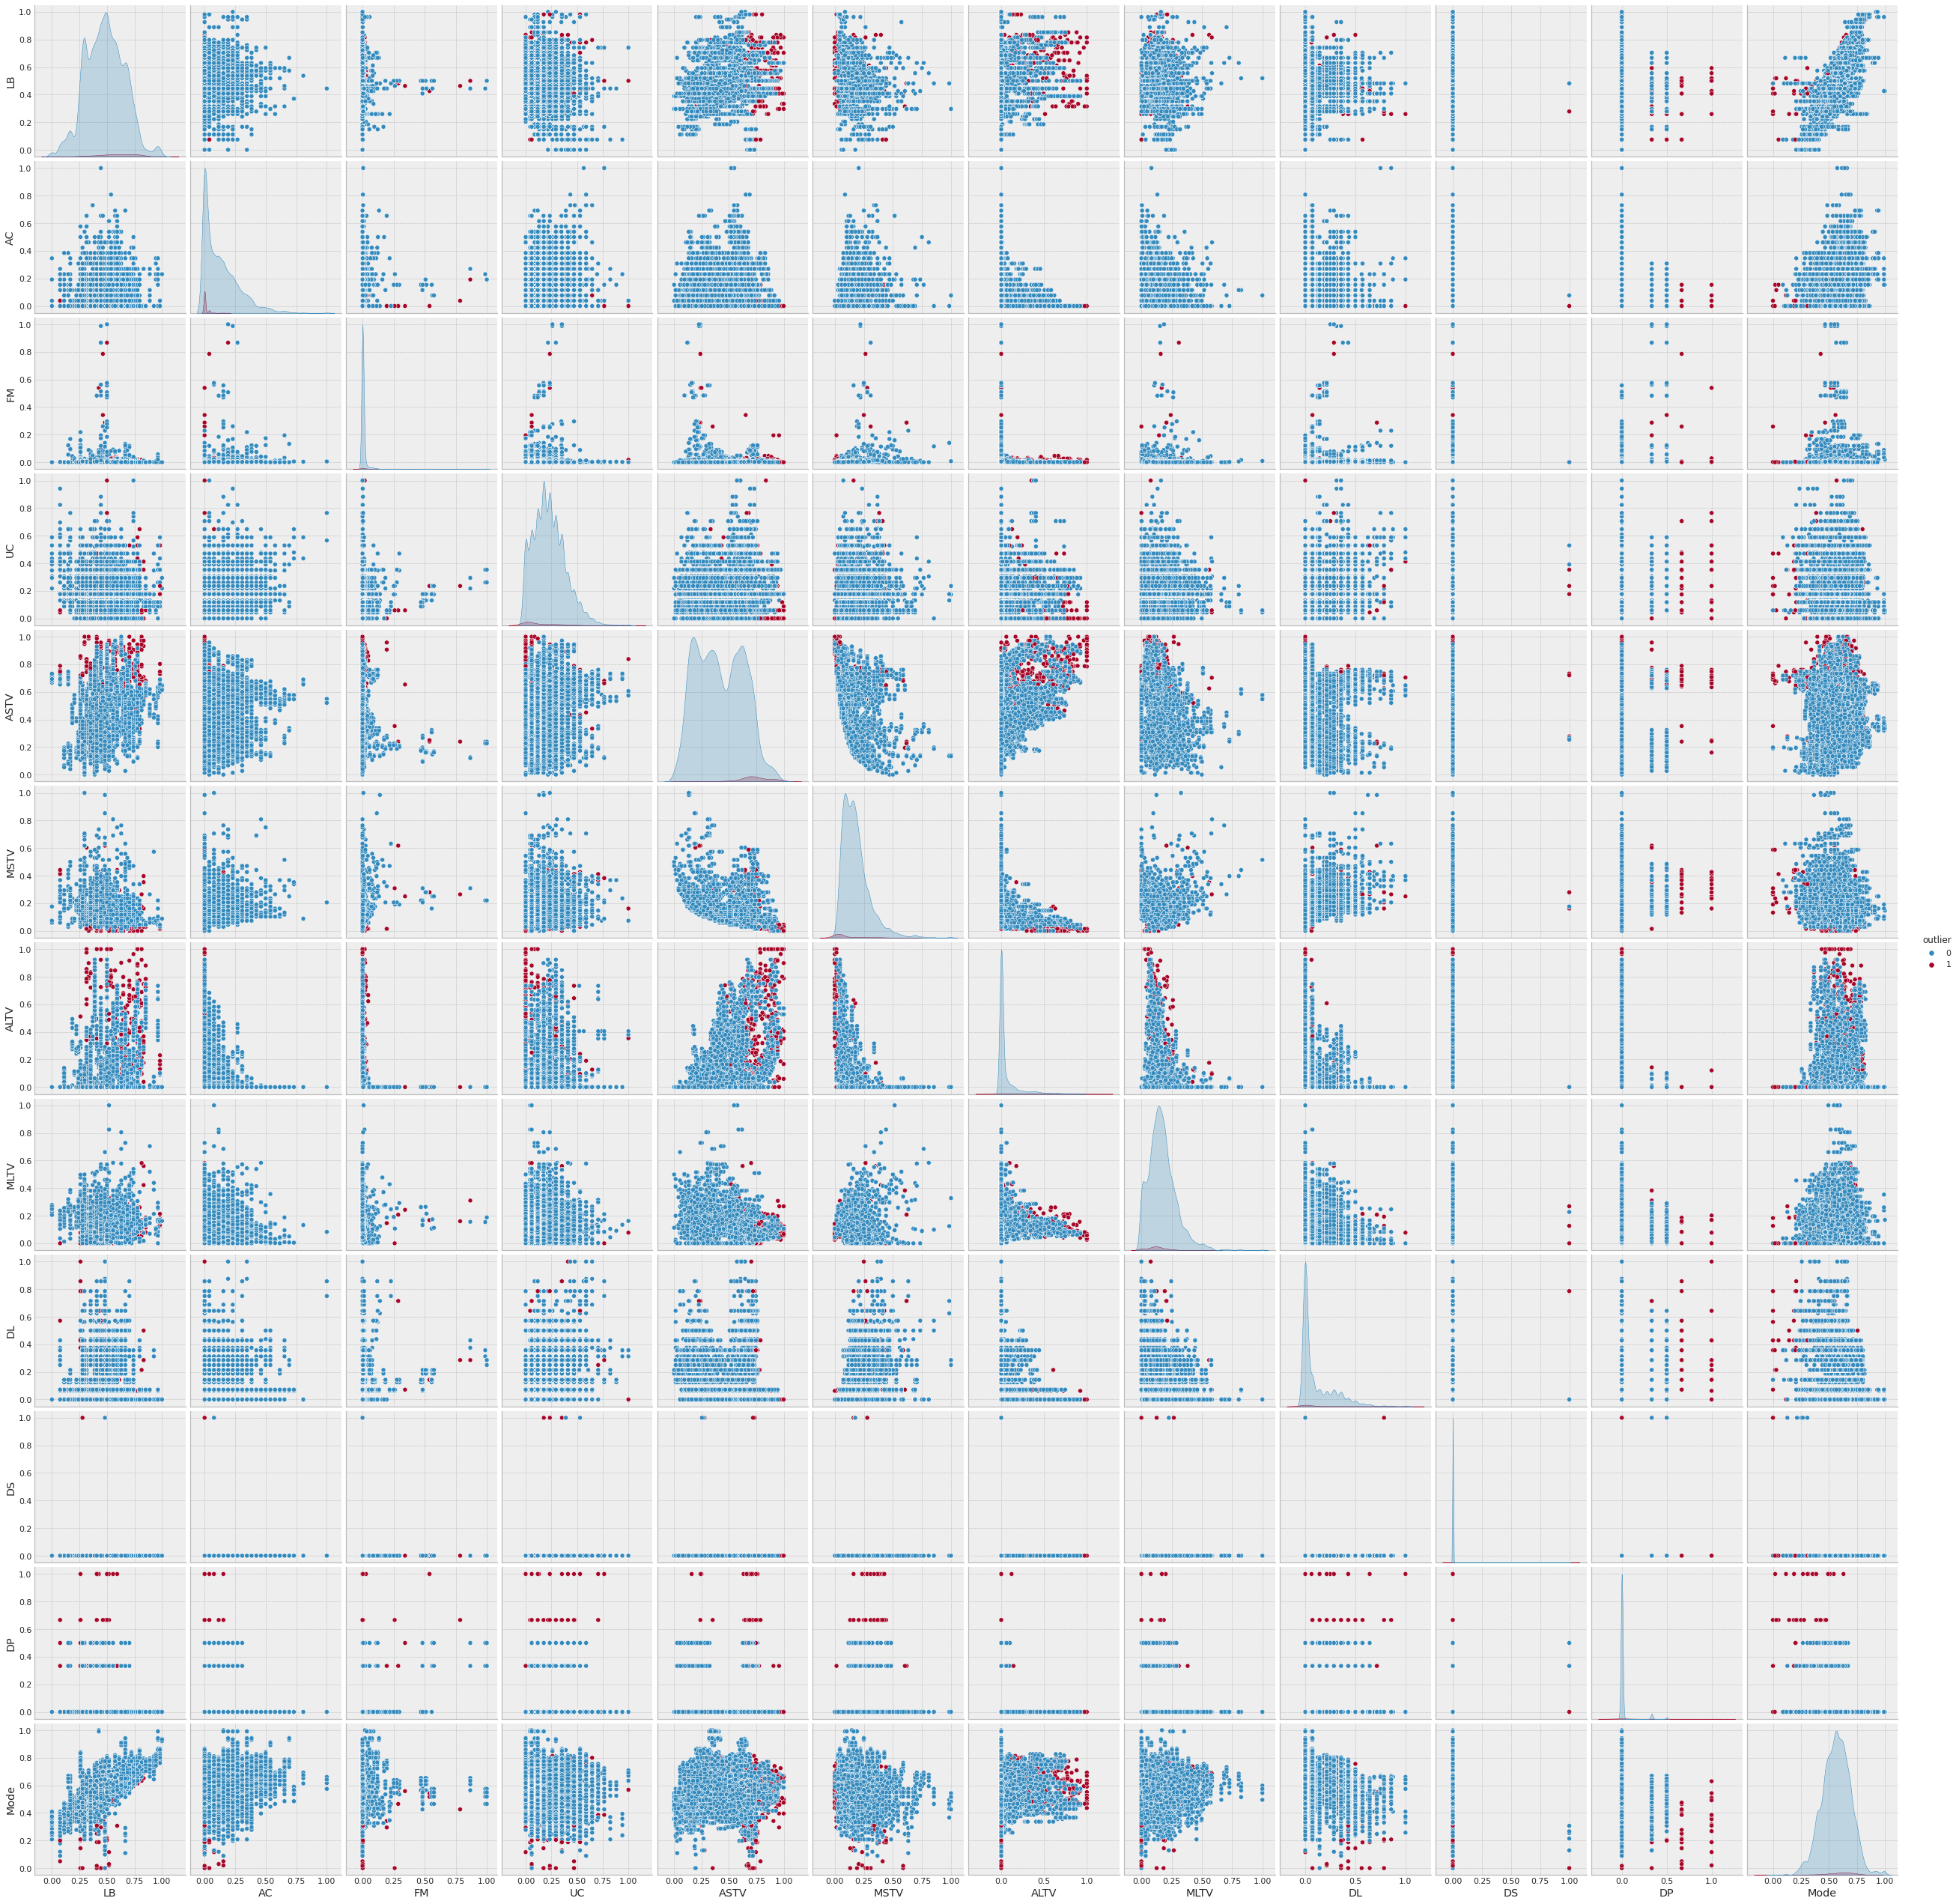

In [ ]:
sns.pairplot(data=df[['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'Mode', 'outlier']], hue='outlier', height=3);
plt.show()

The `ALTV` and `ASTV` features might be helpful when clustering.

Now let's get the correlation.

Text(0.5, 1.0, 'Correlation')

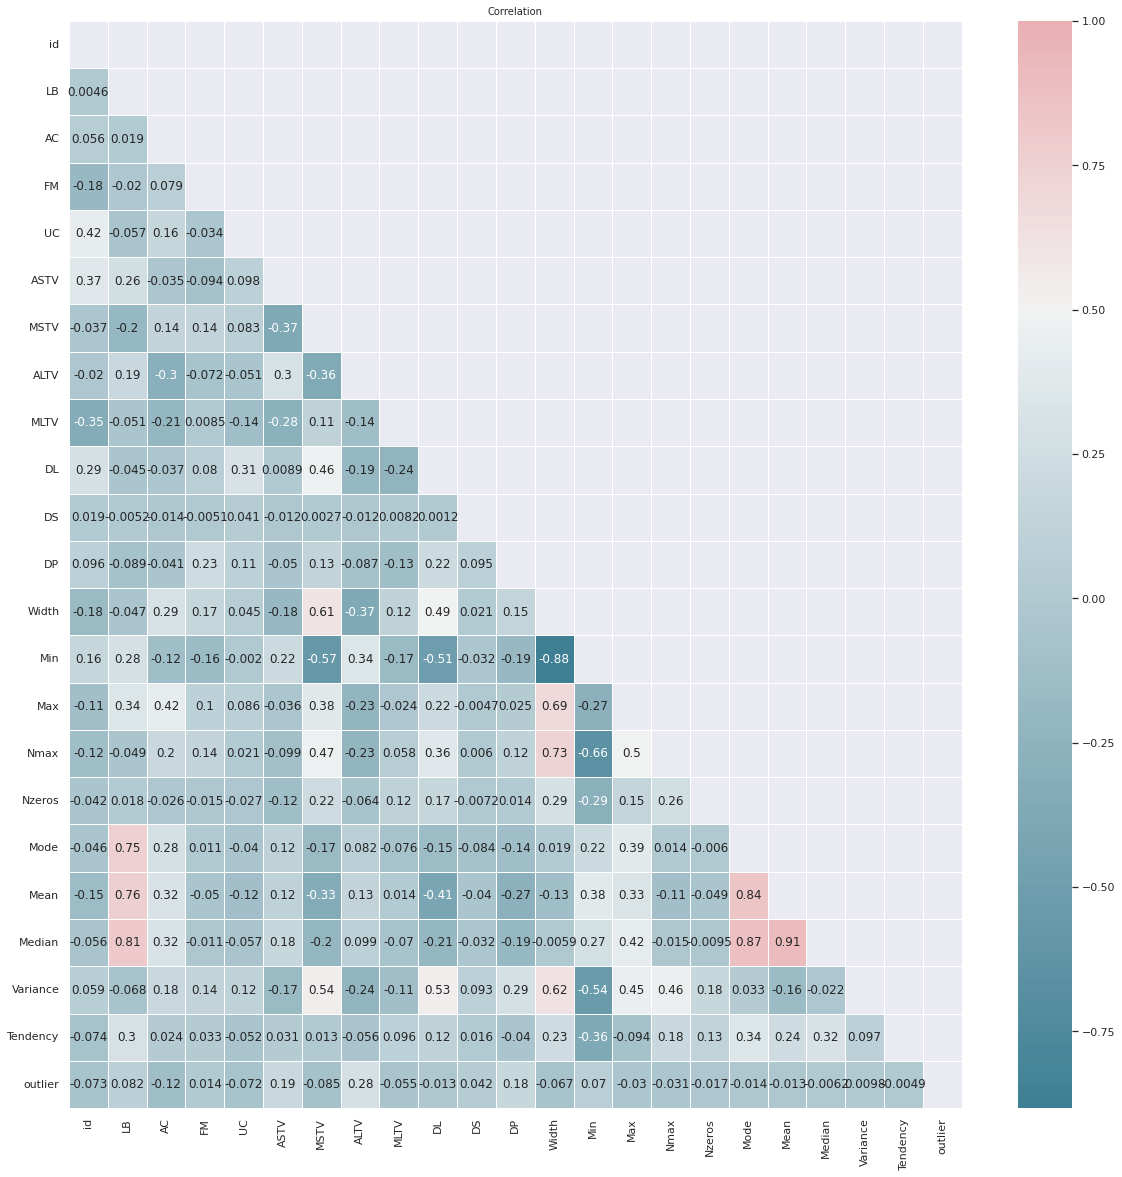

In [ ]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0.5,
            linewidths=.5,
            annot=True
           )
sns.set(rc={'figure.figsize':(20,20)})
plt.title("Correlation", fontsize =10)

It seems some features may create multicollinearity (for example, `Mean`, `Median` and `Mode`). All my attempts to remove highly correlated features in order to completely get rid of multicollinearity worsened the results of future models. Eventially, I came up with reducing three features: `LB`, `Median` and `Width`.

In [ ]:
X_reduced = X.drop(columns = ['LB', 'Median', 'Width'])

#Feature transformations

##Distribution transformation

Here I tried to use various function transformations, but it didn't bring me any profit in future models.

In [ ]:
X_transformed = X.copy()

rng = np.random.RandomState(42)
bc = PowerTransformer(method="box-cox")
yj = PowerTransformer(method="yeo-johnson")
qt = QuantileTransformer(output_distribution="normal", random_state=rng)
scaler = MinMaxScaler()

X_transformed['AC'] = np.sqrt(X['AC'])
X_transformed['FM'] = np.sqrt(X['FM'])
X_transformed['UC'] = np.log(X['UC']+0.5)-min(np.log(X['UC']+0.5))
X_transformed['ASTV'] = qt.fit_transform(X['ASTV'].to_numpy().reshape(-1,1)) ** 1/10
X_transformed['MSTV'] = scaler.fit_transform(yj.fit_transform(X['MSTV'].to_numpy().reshape(-1,1)))
X_transformed['ALTV'] = X['ALTV'] ** (1/4)
X_transformed['MLTV'] = np.log(X['MLTV']+0.1)
X_transformed['DL'] = np.sqrt(X['DL'])
X_transformed['Width'] = scaler.fit_transform(qt.fit_transform(X['Width'].to_numpy().reshape(-1,1)))
X_transformed['Nmax'] = np.sqrt(X['Nmax'])
X_transformed['Variance'] = X['Variance'] ** (1/3)

##Polynomial features

Let's apply `PolynomialFeatures` transformation to the reduced dataset.

In [ ]:
poly = PolynomialFeatures(interaction_only=True)
X_poly = pd.DataFrame(poly.fit_transform(X_reduced))
X_poly

0         1         2         3         4         5         6    \
0      1.0  0.000000  0.000000  0.294118  0.633803  0.338235  0.000000   
1      1.0  0.038462  0.000000  0.000000  0.816901  0.029412  0.527473   
2      1.0  0.000000  0.000000  0.000000  0.774648  0.029412  0.736264   
3      1.0  0.000000  0.000000  0.294118  0.704225  0.191176  0.000000   
4      1.0  0.000000  0.001773  0.294118  0.633803  0.352941  0.000000   
...    ...       ...       ...       ...       ...       ...       ...   
16875  1.0  0.000000  0.000000  0.352941  0.893333  0.014706  0.253165   
16876  1.0  0.000000  0.000000  0.411765  0.893333  0.044118  0.329114   
16877  1.0  0.000000  0.000000  0.352941  0.893333  0.058824  0.341772   
16878  1.0  0.000000  0.000000  0.235294  0.866667  0.073529  0.215190   
16879  1.0  0.038462  0.001773  0.294118  0.826667  0.029412  0.455696   

            7         8    9    ...       162       163       164   165  \
0      0.013807  0.500000  0.0  ...  0.048515  0.024742  0.063842  0.10   
1      0.092702  0.000000  0.0  ...  0.000000  0.000000  0.000000  0.00   
2      0.096647  0.000000  0.0  ...  0.000000  0.000000  0.000000  0.00   
3      0.183432  0.428571  0.0  ...  0.000000  0.016495  0.036158  0.00   
4      0.013807  0.428571  0.0  ...  0.048515  0.022680  0.068362  0.10   
...         ...       ...  ...  ...       ...       ...       ...   ...   
16875  0.167653  0.000000  0.0  ...  0.000000  0.000000  0.000000  0.00   
16876  0.138067  0.071429  0.0  ...  0.000000  0.000000  0.000000  0.00   
16877  0.126233  0.071429  0.0  ...  0.000000  0.000000  0.000000  0.00   
16878  0.118343  0.071429  0.0  ...  0.000000  0.000000  0.000000  0.00   
16879  0.098619  0.000000  0.0  ...  0.065000  0.064220  0.000565  0.05   

            166       167       168       169       170       171  
0      0.120037  0.309728  0.485149  0.157959  0.247423  0.638418  
1      0.314178  0.009062  0.000000  0.009960  0.000000  0.000000  
2      0.418087  0.000000  0.633663  0.000000  0.659794  0.000000  
3      0.000000  0.000000  0.000000  0.059642  0.000000  0.000000  
4      0.110034  0.331655  0.485149  0.155047  0.226804  0.683616  
...         ...       ...       ...       ...       ...       ...  
16875  0.412080  0.003625  0.641667  0.003628  0.642202  0.005650  
16876  0.411468  0.007345  0.650000  0.007153  0.633028  0.011299  
16877  0.400306  0.003625  0.641667  0.003525  0.623853  0.005650  
16878  0.417431  0.007345  0.325000  0.007257  0.321101  0.005650  
16879  0.417431  0.003672  0.325000  0.003628  0.321101  0.002825  

[16880 rows x 172 columns]

#Mahalanobis

In order to use mahalanobis rule we can apply PCA to the dataset.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reduced)

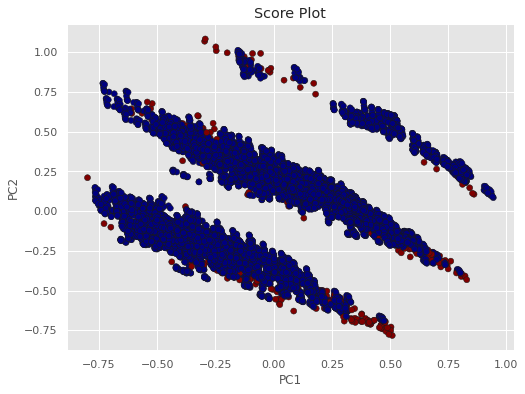

In [ ]:
# Score plot of the PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y.tolist(), edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

Next we can compute mahalanobis distances.

In [ ]:
X_mah = pd.DataFrame(X_pca)
X_mah['mahala'] = mahalanobis(x=X_mah, data=pd.DataFrame(X_pca))
X_mah.head()

0         1    mahala
0 -0.638990  0.052127  3.198626
1  0.805082  0.211263  5.551966
2  0.396973 -0.681419  6.685585
3  0.084453  0.838006  8.318155
4 -0.646344  0.074102  3.304576

And compute the `p-values` using the critical value.

In [ ]:
# Critical values for two degrees of freedom
chi2.ppf((1-0.05), df=2)

5.991464547107979

In [ ]:
# Compute the P-Values
X_mah['p_value'] = 1 - chi2.cdf(X_mah['mahala'], 2)

Depending on the `p-value` we can make conclusions about the classes.

In [ ]:
X_mah['class'] = X_mah.p_value < 0.05
X_mah['class'] = le.fit_transform(X_mah['class'])
X_mah

0         1    mahala   p_value  class
0     -0.638990  0.052127  3.198626  0.202035      0
1      0.805082  0.211263  5.551966  0.062288      0
2      0.396973 -0.681419  6.685585  0.035338      1
3      0.084453  0.838006  8.318155  0.015622      1
4     -0.646344  0.074102  3.304576  0.191611      0
...         ...       ...       ...       ...    ...
16875  0.293700 -0.615852  5.131593  0.076858      0
16876  0.308607 -0.610684  5.126647  0.077048      0
16877  0.280620 -0.600845  4.858495  0.088103      0
16878  0.489593 -0.189363  2.280936  0.319669      0
16879  0.496770 -0.210320  2.434390  0.296059      0

[16880 rows x 5 columns]

In [ ]:
X_mah['class'].value_counts()

0    16445
1      435
Name: class, dtype: int64

In [ ]:
print(classification_report(y, X_mah['class']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.17      0.23      0.20       330

    accuracy                           0.96     16880
   macro avg       0.58      0.60      0.59     16880
weighted avg       0.97      0.96      0.97     16880



As we can see, the results are quite bad. I tried to use `KernelPCA` with different kernels and `TSNE` instead of `PCA` but it didn't give any improvement.

#Train-test split

Now we can form all the train and test datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_train_reduced, X_test_reduced = train_test_split(X_reduced, test_size = 0.25, random_state = 0)
X_train_poly, X_test_poly = train_test_split(X_poly, test_size = 0.25, random_state = 0)
X_train_transformed, X_test_transformed = train_test_split(X_transformed, test_size = 0.25, random_state = 0)

#Oversampling

Since the data is imbalanced, we can try different oversampling methods.

In [ ]:
smt = SMOTE(random_state=0)
X_train_sm, y_train_sm = smt.fit_resample(X_train_reduced, y_train)

ada = ADASYN(random_state=0)
X_train_ada, y_train_ada = ada.fit_resample(X_train_reduced, y_train)

smtom = SMOTETomek(random_state=0)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train_reduced, y_train)

smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train_reduced, y_train)

In [ ]:
oversampled_data = {
    'ACTUAL':[X_train_reduced, y_train],
    'SMOTE':[X_train_sm, y_train_sm],
    'ADASYN':[X_train_ada, y_train_ada],
    'SMOTE_TOMEK':[X_train_smtom, y_train_smtom],
    'SMOTE_ENN':[X_train_smenn, y_train_smenn]
}

#Supervised models

First I'd like to test the oversampling methods on supervised models with default parameters. I'll use `roc-auc` metric, `classification report` and `confusion matrix` to evaluate the performance of the models. Since the data is imbalanced, I'd like to look at the precision, recall and f1-score. Since we are dealing with medical diagnoses, I think it's preferable to maximize recall as false negatives are more costly than false positives.

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(random_state=0),
    'LinearSVC':LinearSVC(random_state=0),
    'KNN':KNeighborsClassifier()
}

In [ ]:
for model_k, model_clf in models.items():
  for data_type, data in oversampled_data.items():
    model_clf.fit(data[0], data[1])
    print_model(model_k, data_type)
    build_model(model_clf, data[0], data[1], X_test_reduced, y_test)

--------------------------------------------
Model  LogisticRegression
Data Type  ACTUAL
Accuracy Score: 0.9902843601895734
Confusion Matrix: 
[[4162    1]
 [  40   17]]
Area Under Curve: 0.6490027013245341
Recall score: 0.2982456140350877
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4163
           1       0.94      0.30      0.45        57

    accuracy                           0.99      4220
   macro avg       0.97      0.65      0.72      4220
weighted avg       0.99      0.99      0.99      4220

--------------------------------------------
Model  LogisticRegression
Data Type  SMOTE
Accuracy Score: 0.8829383886255924
Confusion Matrix: 
[[3672  491]
 [   3   54]]
Area Under Curve: 0.9147123152584801
Recall score: 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      4163
           1       0.10      0.95      0.18        57

    accuracy                  

We can say that oversampling improves the performance of the models. For the `KNN` model, the `SMOTE_TOMEK` method performed best. As for now, the `LogisticRegression` and `SVC` models give the fewest false-negatives (2) while the `KNN` gives the fewest false-positives (9).

##Logistic regression

I'd like to try `LogisticRegression` with hyperparameter `class_weight: balanced` on different datasets: initial, reduced, transformed, polynomial and oversampled to choose the best one to work with.

In [ ]:
datas = {
    'ACTUAL':[X_train, y_train, X_test],
    'REDUCED':[X_train_reduced, y_train, X_test_reduced],
    'TRANSFORMED':[X_train_transformed, y_train, X_test_transformed],
    'POLYNOMIAL':[X_train_poly, y_train, X_test_poly],
    'SMOTE_ENN':[X_train_smenn, y_train_smenn, X_test_reduced]
}

In [ ]:
lr = LogisticRegression(class_weight='balanced')

In [ ]:
for data_type, data in datas.items():
  lr.fit(data[0], data[1])
  print_model('Logistic regression', data_type)
  build_model(lr, data[0], data[1], data[2], y_test)

--------------------------------------------
Model  Logistic regression
Data Type  ACTUAL
Accuracy Score: 0.8781990521327014
Confusion Matrix: 
[[3652  511]
 [   3   54]]
Area Under Curve: 0.9123102013982831
Recall score: 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      4163
           1       0.10      0.95      0.17        57

    accuracy                           0.88      4220
   macro avg       0.55      0.91      0.55      4220
weighted avg       0.99      0.88      0.92      4220

--------------------------------------------
Model  Logistic regression
Data Type  REDUCED
Accuracy Score: 0.8755924170616114
Confusion Matrix: 
[[3641  522]
 [   3   54]]
Area Under Curve: 0.9109890387751747
Recall score: 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      4163
           1       0.09      0.95      0.17        57

    accuracy              

The dataset created by the `PolynomialFeatures` method performed best. I'll use it to tune hyperparameters.

In [ ]:
lr = LogisticRegression()

param = {
    'C':[0.001,0.003],
    'class_weight' : ['balanced'],
    'penalty' : ['l2', 'none'],
    'fit_intercept' : [True],
}

grid_lr = grid_search(model=lr, param=param, cv=4, X=X_poly, y=y)

Best roc-auc: 0.9737234787206195, with best: {'C': 0.001, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'none'}


In [ ]:
lr = LogisticRegression()

param = {
    'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,13,14,15,20,50,100],
    'class_weight' : ['balanced', {0: 1, 1: 85}, {0: 1, 1: 100}, {0: 1, 1: 90}],
    'penalty' : ['l2', 'none'],
    'fit_intercept' : [True, False],
}

grid_lr = grid_search(model=lr, param=param, cv=4, X=X_poly, y=y)

Best roc-auc: 0.9766115940571525, with best: {'C': 20, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2'}


In [ ]:
build_model(grid_lr, X_train_poly, y_train, X_test_poly, y_test)

Accuracy Score: 0.9350710900473934
Confusion Matrix: 
[[3889  274]
 [   0   57]]
Area Under Curve: 0.9670910401153014
Recall score: 1.0
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      4163
           1       0.17      1.00      0.29        57

    accuracy                           0.94      4220
   macro avg       0.59      0.97      0.63      4220
weighted avg       0.99      0.94      0.96      4220



We got 1.00 recall which means that the number of false-negatives is 0. The model gave 274 false-positives - about 6.5%.

##SVM

Next I'll use `SVC` model with `class_weight: balanced`.

In [ ]:
svc = SVC(random_state=0, class_weight='balanced')

build_model(svc, X_train_poly, y_train, X_test_poly, y_test)

Accuracy Score: 0.9222748815165877
Confusion Matrix: 
[[3836  327]
 [   1   56]]
Area Under Curve: 0.9519535085612181
Recall score: 0.9824561403508771
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4163
           1       0.15      0.98      0.25        57

    accuracy                           0.92      4220
   macro avg       0.57      0.95      0.61      4220
weighted avg       0.99      0.92      0.95      4220



And tune it.

In [ ]:
svc = SVC(random_state=0)

param = {
    'C':[0.1, 1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'class_weight' : ['balanced'],
    'kernel':['linear','rbf']
}

grid_svc = grid_search(model=svc, param=param, cv=4, X=X_poly, y=y)

Best roc-auc: 0.9827436305504864, with best: {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
build_model(grid_svc, X_train_poly, y_train, X_test_poly, y_test)

Accuracy Score: 0.9919431279620853
Confusion Matrix: 
[[4133   30]
 [   4   53]]
Area Under Curve: 0.9613091099114589
Recall score: 0.9298245614035088
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4163
           1       0.64      0.93      0.76        57

    accuracy                           0.99      4220
   macro avg       0.82      0.96      0.88      4220
weighted avg       0.99      0.99      0.99      4220



The model gave 4 false-negative (7%) and 30 false-positive (0.7%) results.

##KNN

Next I'll try `KNeighborsClassifier` on polynomial and reduced datasets.

In [ ]:
knn = KNeighborsClassifier()

build_model(knn, X_train_poly, y_train, X_test_poly, y_test)

Accuracy Score: 0.9943127962085309
Confusion Matrix: 
[[4163    0]
 [  24   33]]
Area Under Curve: 0.7894736842105263
Recall score: 0.5789473684210527
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4163
           1       1.00      0.58      0.73        57

    accuracy                           0.99      4220
   macro avg       1.00      0.79      0.87      4220
weighted avg       0.99      0.99      0.99      4220



In [ ]:
build_model(knn, X_train_reduced, y_train, X_test_reduced, y_test)

Accuracy Score: 0.9943127962085309
Confusion Matrix: 
[[4163    0]
 [  24   33]]
Area Under Curve: 0.7894736842105263
Recall score: 0.5789473684210527
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4163
           1       1.00      0.58      0.73        57

    accuracy                           0.99      4220
   macro avg       1.00      0.79      0.87      4220
weighted avg       0.99      0.99      0.99      4220



Here the performance of both models is the same. I'll use the reduced dataset to tune hyperparameters as it has fewer features. Also I'll apply `SMOTETomek` method for oversampling.

In [ ]:
smt = SMOTETomek(random_state=0)
knn = KNeighborsClassifier()

pipe = Pipeline([('smt', smt), ('knn', knn)])

k_range = list(range(1, 31))
param = {
    'knn__n_neighbors': k_range,
    'knn__metric':['manhattan', 'minkowski', 'euclidean'],
    'knn__weights' : ['uniform', 'distance'],
}

grid_knn = grid_search(model=pipe, param=param, cv=4, X=X_reduced, y=y)

Best roc-auc: 0.9551482193536573, with best: {'knn__metric': 'minkowski', 'knn__n_neighbors': 28, 'knn__weights': 'distance'}


In [ ]:
build_model(grid_knn, X_train_smtom, y_train_smtom, X_test_reduced, y_test)

Accuracy Score: 0.9924170616113744
Confusion Matrix: 
[[4134   29]
 [   3   54]]
Area Under Curve: 0.97020114542903
Recall score: 0.9473684210526315
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4163
           1       0.65      0.95      0.77        57

    accuracy                           0.99      4220
   macro avg       0.82      0.97      0.88      4220
weighted avg       0.99      0.99      0.99      4220



The model gave 3 false-negative (5%) and 29 false-positive (0.7%) results.

##Conclusions

The `KNN` model shows the best ROC-AUC score among these three models. The number of false-positives is very low. Comparing `SVC` and `KNN` I'd choose `KNN` since all of its metrics are better. But, if the goal is to minimize false-negative rate, we can look at `LogisticRegression` as it recognized all outliers as outliers.

#Unsupervised models

##One-class SVM

I'll set the `nu` parameter close to the content of the outliers in the dataset.

In [ ]:
def fit_predict_print(model, X, y):
  pred = model.fit_predict(X)
  pred[pred==-1] = 0
  pred = 1 - pred

  print(classification_report(y, pred))
  print(confusion_matrix(y, pred))

In [ ]:
ocsvm = OneClassSVM(nu=0.02)
ocsm_preds = ocsvm.fit_predict(X_poly)

In [ ]:
pd.DataFrame(ocsm_preds).value_counts()

 1    16542
-1      338
dtype: int64

This model returns -1 for outliers and 1 for inliers while in our dataset the corresponding values are 1 and 0 so we need to change the labels.

In [ ]:
fit_predict_print(ocsvm, X_reduced, y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.22      0.23      0.23       330

    accuracy                           0.97     16880
   macro avg       0.60      0.61      0.61     16880
weighted avg       0.97      0.97      0.97     16880

[[16290   260]
 [  255    75]]


In [ ]:
fit_predict_print(ocsvm, X_poly, y)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     16550
           1       0.22      0.23      0.22       330

    accuracy                           0.97     16880
   macro avg       0.60      0.61      0.60     16880
weighted avg       0.97      0.97      0.97     16880

[[16287   263]
 [  255    75]]


Now we can tune the hyperparameters.

In [ ]:
optimal_nu = 0
optimal_kernel = None
optimal_gamma = 0

max_roc_auc = 0

for nu_value in np.arange(0.09, 0.26, 0.02):
  for kernel_value in ['linear', 'poly', 'rbf', 'sigmoid']:
    for gamma_value in ['scale', 'auto', 1, 0.1, 0.01, 0.001]:
      model = OneClassSVM(kernel=kernel_value, gamma=gamma_value, nu=np.round_(nu_value, decimals=2), max_iter=-1)
      model.fit(X_train_poly)

      preds = model.predict(X_test_poly)
      preds[preds==-1] = 0
      preds = 1 - preds

      roc_auc = roc_auc_score(y_test, preds)
      if(roc_auc > max_roc_auc):
          max_roc_auc = roc_auc
          optimal_nu = nu_value
          optimal_kernel = kernel_value
          optimal_gamma = gamma_value

      print(f'nu: {nu_value: .2f}, gamma: {gamma_value}, kernel: {kernel_value}, roc_auc: {roc_auc_score(y_test, preds)}')
      print(classification_report(y_test, preds))
      print(confusion_matrix(y_test, preds))

print(f'Best parameters: nu: {optimal_nu}, kernel: {optimal_kernel}, gamma: {optimal_gamma}')

nu:  0.09, gamma: scale, kernel: linear, roc_auc: 0.5516918045775019
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4163
           1       0.03      0.19      0.05        57

    accuracy                           0.90      4220
   macro avg       0.51      0.55      0.50      4220
weighted avg       0.98      0.90      0.94      4220

[[3790  373]
 [  46   11]]
nu:  0.09, gamma: auto, kernel: linear, roc_auc: 0.5516918045775019
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4163
           1       0.03      0.19      0.05        57

    accuracy                           0.90      4220
   macro avg       0.51      0.55      0.50      4220
weighted avg       0.98      0.90      0.94      4220

[[3790  373]
 [  46   11]]
nu:  0.09, gamma: 1, kernel: linear, roc_auc: 0.5516918045775019
              precision    recall  f1-score   support

           0       0.99      0.91  

In [ ]:
ocsvm_tuned = OneClassSVM(gamma='auto', nu=0.23, kernel='rbf')

fit_predict_print(ocsvm_tuned, X_poly, y)

              precision    recall  f1-score   support

           0       0.99      0.78      0.87     16550
           1       0.07      0.77      0.12       330

    accuracy                           0.78     16880
   macro avg       0.53      0.78      0.50     16880
weighted avg       0.98      0.78      0.86     16880

[[12922  3628]
 [   76   254]]


The model gave 76 false-negative (23%) and 3628 false-positive (22%) results.

##Isolation Forest

Let's set the `contamination` parameter as 0.2.

In [ ]:
isfor = IsolationForest(contamination=0.2, random_state=0)

In [ ]:
fit_predict_print(isfor, X_reduced, y)

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     16550
           1       0.06      0.62      0.11       330

    accuracy                           0.80     16880
   macro avg       0.53      0.71      0.50     16880
weighted avg       0.97      0.80      0.88     16880

[[13378  3172]
 [  126   204]]


Let's tune the hyperparameters.

In [ ]:
param_if = {
  'n_estimators' : [50, 100, 150, 200, 250, 300, 400, 500, 600],
  'contamination' : [0.02, 0.05, 0.1, 0.2],
  'bootstrap':[True, False],
}

In [ ]:
optimal_n_estimators = 0
optimal_contamination = 0
optimal_bootstrap = False

max_roc_auc = 0

for n_estimators_value in param_if['n_estimators']:
  for contamination_value in param_if['contamination']:
    for bootstrap_value in param_if['bootstrap']:
      model = IsolationForest(n_estimators=n_estimators_value, contamination=contamination_value, bootstrap=bootstrap_value)
      model.fit(X_train_reduced)

      preds = model.predict(X_test_reduced)
      preds[preds==-1] = 0
      preds = 1 - preds

      roc_auc = roc_auc_score(y_test, preds)
      if(roc_auc > max_roc_auc):
          max_roc_auc = roc_auc
          optimal_n_estimators = n_estimators_value
          optimal_contamination = contamination_value
          optimal_bootstrap = bootstrap_value

      print(f'n_estimators: {n_estimators_value}, contamination: {contamination_value}, bootstrap: {bootstrap_value}, roc_auc: {roc_auc_score(y_test, preds)}')
      print(classification_report(y_test, preds))
      print(confusion_matrix(y_test, preds))

print(f'Best parameters: n_estimators: {optimal_n_estimators}, contamination: {optimal_contamination}, bootstrap: {optimal_bootstrap}')

n_estimators: 50, contamination: 0.02, bootstrap: True, roc_auc: 0.5430231235065804
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4163
           1       0.07      0.11      0.08        57

    accuracy                           0.97      4220
   macro avg       0.53      0.54      0.53      4220
weighted avg       0.98      0.97      0.97      4220

[[4083   80]
 [  51    6]]
n_estimators: 50, contamination: 0.02, bootstrap: False, roc_auc: 0.544224180436679
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4163
           1       0.08      0.11      0.09        57

    accuracy                           0.97      4220
   macro avg       0.53      0.54      0.54      4220
weighted avg       0.98      0.97      0.97      4220

[[4093   70]
 [  51    6]]
n_estimators: 50, contamination: 0.05, bootstrap: True, roc_auc: 0.6001070415649982
              precision    recall  f1-sc

And try model with the best parameters.

In [ ]:
isfor_tuned = IsolationForest(n_estimators=50, contamination=0.2, bootstrap=True, random_state=0)

fit_predict_print(isfor_tuned, X_reduced, y)

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     16550
           1       0.06      0.65      0.12       330

    accuracy                           0.81     16880
   macro avg       0.53      0.73      0.50     16880
weighted avg       0.97      0.81      0.88     16880

[[13390  3160]
 [  114   216]]


The model gave 125 false-negative (38%) and 3171 false-positive (19%) results.

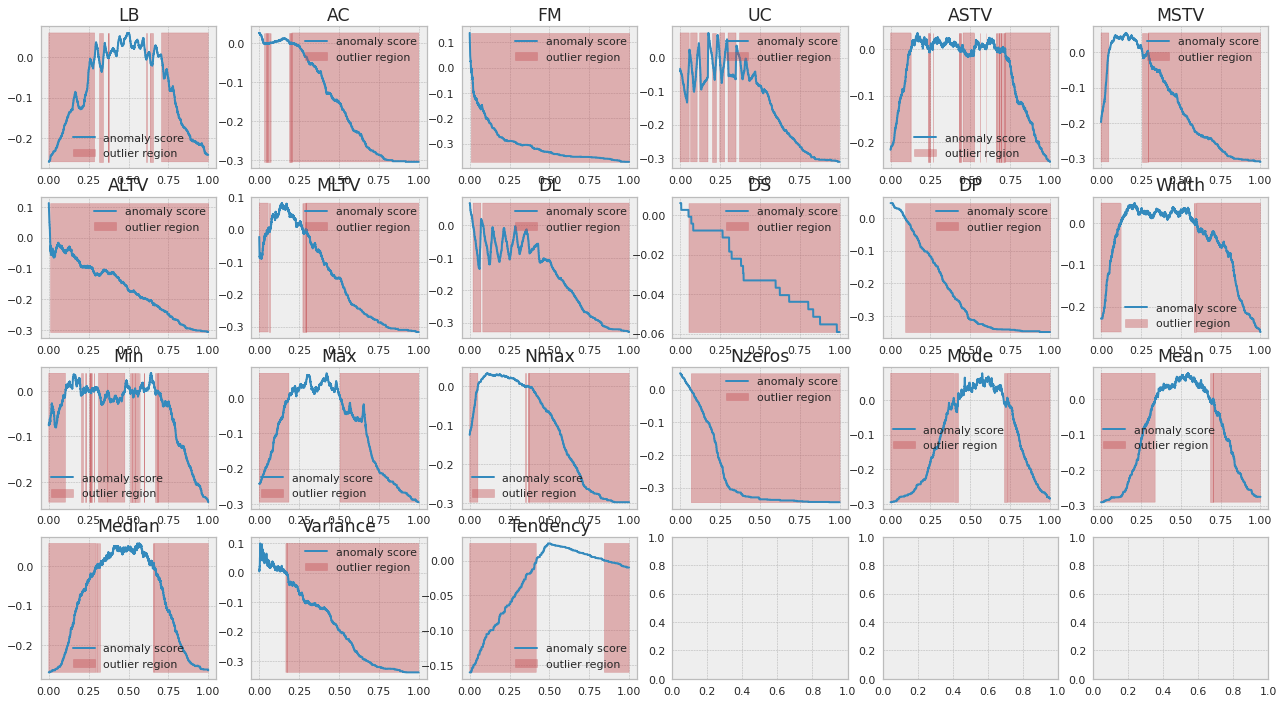

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(22, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()

cols = X.columns.tolist()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(X[column].values.reshape(-1,1))

    xx = np.linspace(X[column].min(), X[column].max(), len(X)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)

    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                     where=outlier==-1, color='r',
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)

##Conclusions

`OneClassSVM` gives false-negatives less often than `IsolationForest`. However, the performance of both models leaves much to be desired. Maybe, more attention needs to be paid to data preprocessing, e.g. feature engineering or feature selection.